# Спирина Татьяна DS-22

## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
# ! pip install torchtext

In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_to_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_to_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_to_data = './data.txt'

Dataset not found locally. Downloading from github.
--2022-06-08 07:28:53--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.07s   

2022-06-08 07:28:55 (175 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
torch.__version__

'1.10.0+cu102'

In [ ]:
! pip install torchtext==0.11

In [ ]:
! pip install datasets transformers[sentencepiece] sacrebleu

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext

import math
import time
import numpy as np
import pandas as pd
import json


import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output


In [ ]:
import pipeline

In [ ]:
train_data, valid_data, test_data, SRC, TRG = pipeline.process_dataset(path_to_data)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9259
Unique tokens in target (en) vocabulary: 6726


In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 'автобусе',
 'red',
 'кафедральный',
 'chiado',
 'укомплектованным',
 'lovely',
 'флик',
 'душа',
 'ташкента']

In [ ]:
TRG.vocab.itos[::1000]

['<unk>', 'order', 'generous', 'cebu', 'lan', 'shenyang', 'mackerel']

In [ ]:
print(vars(train_data.examples[35500]))

{'trg': ['a', 'continental', 'breakfast', 'is', 'offered', 'at', 'surcharge', '.'], 'src': ['континентальный', 'завтрак', 'накрывают', 'за', 'дополнительную', 'плату', '.']}


In [ ]:
print(vars(test_data.examples[1]))

{'trg': ['a', 'refrigerator', 'is', 'included', 'in', 'all', 'guest', 'rooms', 'at', 'premier', 'inns', 'thousand', 'oaks', '.'], 'src': ['все', 'номера', 'отеля', 'premier', 'inns', 'thousand', 'oaks', 'оборудованы', 'холодильником', '.']}


Length distribution in Train data


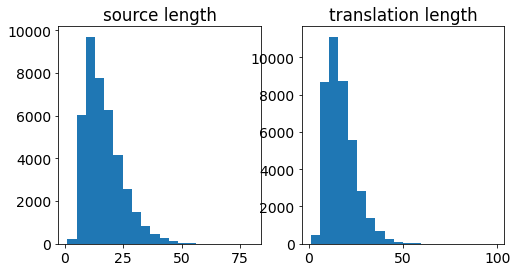

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


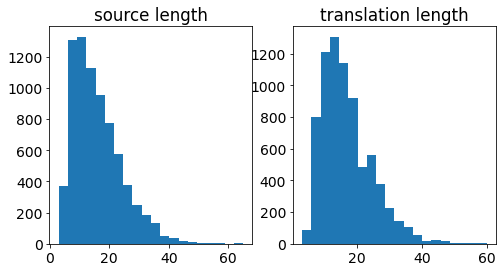

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Помимо baseline у меня в плане было: что-то с attention, transformer, посмотреть предобученную модель вместе с готовой реализацией transformer, попробовать Bert. 

# Baseline
Предложенная изначально в ноутбуке модель

In [ ]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline_model = pipeline.model_init(Encoder, Decoder, Seq2Seq, SRC, TRG, device)

cuda
The model has 14,899,014 trainable parameters


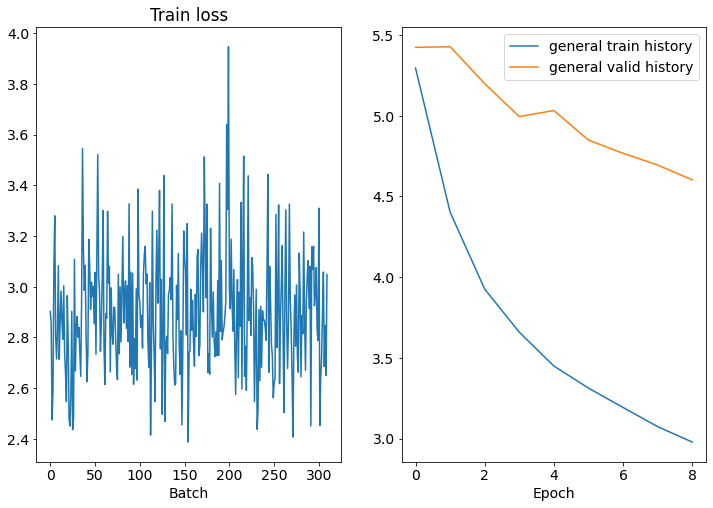

Epoch: 10 | Time: 1m 47s
	Train Loss: 2.899 | Train PPL:  18.147
	 Val. Loss: 4.659 |  Val. PPL: 105.558


In [ ]:
model, test_iterator, bleu_baseline = pipeline.train_loop(baseline_model, "baseline", device, train_data, valid_data, test_data, SRC, TRG, N_EPOCHS = 10)

In [ ]:
 bl_test_bleu, bl_test_loss = pipeline.sample_and_bleu(model, test_iterator, test_data, TRG, device)

59it [00:04, 13.21it/s]


BLEU:  14.993061670060895 

-------
Примеры сгенерированных переводов:
Original: room service is also available .
Generated: room service is available .

Original: in fly fishing , this attractive beachfront lodge is located in punta , at the end of the ka ’ an biosphere reserve ’ s boca peninsula .
Generated: this hotel is located in the heart of the of , , the of the and .

Original: a tv is offered .
Generated: a tv .

Original: is 43 km from villa in loutraki , while town is 48 km away .
Generated: is is km from , while is is km from the property .

Original: restaurants and grocery shops are found within 50 metres of the property .
Generated: shops and restaurants can be found within metres away .

Original: each comprises a kitchenette , a dining area and a flat - screen cable tv .
Generated: the apartment is a living area with a flat - screen tv and a channels .

-------
Удачные переводы
Original: free private parking is available at a location nearby .
Generated: free private p

За 10 эпох результат, мягко говоря, средний

Для определения "удачных" и "неудачных" переводов я не придумала ничего лучше, чем найти батчи с наибольшим\наименьшим лоссом и взять оттуда экземпляр предложения. На глаз, не могу утверждать, что примеры идеально подходят. Но, судя по всему, более длинные предложения попадают в категорию худших результатов. 

# GRU + Attention
На основе семинара с 4й лекции и github.com/bentrevett/pytorch-seq2seq

In [ ]:
import gru_attention
Encoder = gru_attention.Encoder
Attention = gru_attention.Attention
Decoder = gru_attention.Decoder

Seq2Seq = gru_attention.Seq2Seq

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gru_att_model = pipeline.model_init(Encoder, Decoder, Seq2Seq, SRC, TRG, device, attention=Attention)

cuda
The model has 22,585,158 trainable parameters


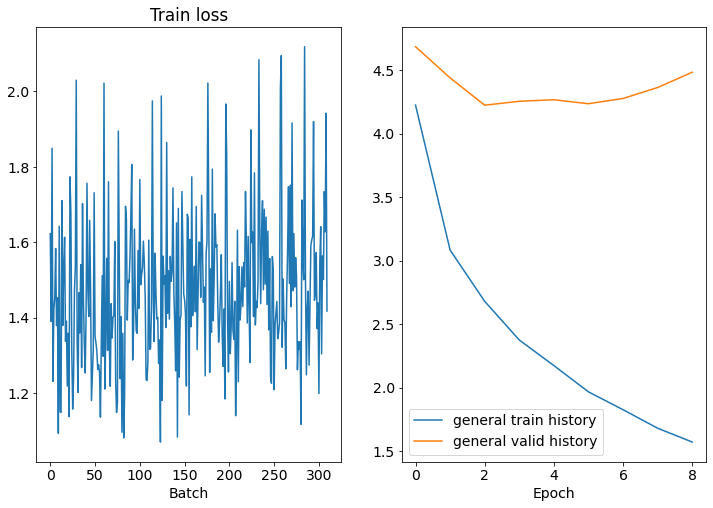

Epoch: 10 | Time: 4m 27s
	Train Loss: 1.474 | Train PPL:   4.365
	 Val. Loss: 4.476 |  Val. PPL:  87.881


In [ ]:
att_model, att_test_iterator, bleu_att = pipeline.train_loop(gru_att_model, "gru_att", device, train_data, valid_data, test_data, SRC, TRG, N_EPOCHS = 10)

In [ ]:
 att_test_bleu, att_test_loss = pipeline.sample_and_bleu(att_model, att_test_iterator, test_data, TRG, device)

59it [00:07,  7.72it/s]


BLEU:  33.20767422968306 

-------
Примеры сгенерированных переводов:
Original: room service is also available .
Generated: room service is also available .

Original: in fly fishing , this attractive beachfront lodge is located in punta , at the end of the ka ’ an biosphere reserve ’ s boca peninsula .
Generated: this beautiful of , this beautiful of , on the of , , fishing .

Original: a tv is offered .
Generated: a tv is offered .

Original: is 43 km from villa in loutraki , while town is 48 km away .
Generated: - is 43 km from villa in , while is 48 km away .

Original: restaurants and grocery shops are found within 50 metres of the property .
Generated: restaurants and grocery stores are be found 50 metres from the chalet .

Original: each comprises a kitchenette , a dining area and a flat - screen cable tv .
Generated: the kitchenette is equipped with a kitchenette , dining area and a flat - screen cable tv .

-------
Удачные переводы
Original: the kitchen features a microwave .


Результат немного лучше, хотя до идеала еще далеко. По графику Лосс кажется, что началось переобучение. Посмотрим в конце графики Bleu. Училась модель ощутимо дольше.

# Transformer
На основе упомянутого на лекции github.com/bentrevett/pytorch-seq2seq

In [ ]:
import transformer
train_data, valid_data, test_data, SRC, TRG = pipeline.process_dataset(path_to_data, bf=True)

Encoder = transformer.Encoder

Decoder = transformer.Decoder

Seq2Seq = transformer.Seq2Seq

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transf_model = pipeline.transformer_init(Encoder, Decoder, Seq2Seq, SRC, TRG, device)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9247
Unique tokens in target (en) vocabulary: 6712
cuda
The model has 8,497,464 trainable parameters


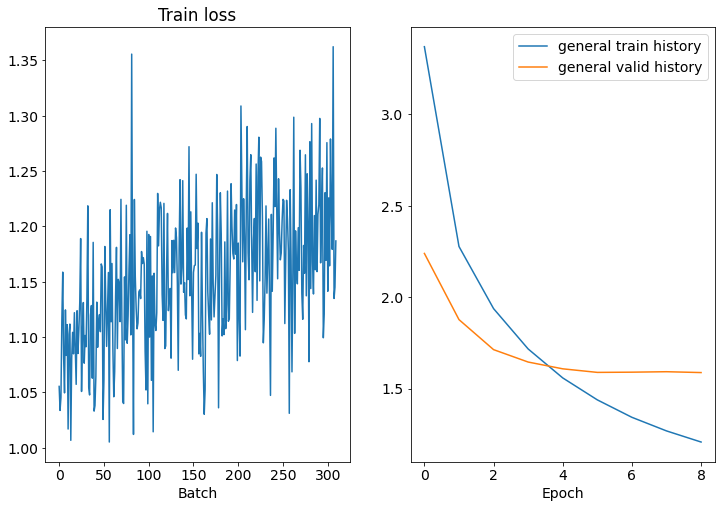

Epoch: 10 | Time: 0m 40s
	Train Loss: 1.154 | Train PPL:   3.172
	 Val. Loss: 1.591 |  Val. PPL:   4.911


In [ ]:
transformer_model, tr_test_iterator, bleu_transf = pipeline.train_loop(transf_model, "transformer", device, train_data, valid_data, test_data, SRC, TRG, N_EPOCHS = 10, transformer=True)

In [ ]:
tr_test_bleu, tr_test_loss = pipeline.sample_and_bleu(transformer_model, tr_test_iterator, test_data, TRG, device, transformer=True)

59it [00:01, 47.07it/s]


BLEU:  38.29633014644783 

-------
Примеры сгенерированных переводов:
Original: free private parking is available .
Generated: free private parking is available on

Original: situated right next to the shopping and entertainment area in oslo , hotel atrium offers free wi - fi and rooms with flat - screen cable tvs .
Generated: located just outside to the bruges and and area the district , bruges , hotel offers offers rooms wi - fi and rooms with flat - screen tv tv .

Original: the property offers free parking .
Generated: the property offers free parking .

Original: every room has a private balcony , an lcd satellite tv , an en suite bathroom and free wi - fi .
Generated: they room has a private balcony , lcd lcd tv tv and and en suite bathroom and free wifi - fi .

Original: amenities include satellite tv and a fridge .
Generated: rooms include cable tv and a refrigerator .

Original: the hotel also provides luggage storage and airport shuttle services on request .
Generated: luggag

По прежнему хуже перевод считается у длинных предложений и предложений с неизвестными словами. Не знаю как надо было генерировать эти примеры.
Перевод на глаз вышел лучше, однако некоторые слова имеют тенденцию дублироваться. 

Данная модель обучалась быстрее предыдущих. Лучше стали все метрики.
Так же прочувствовала, что стратегия инициализации весов дает разницу в результатах.


### Промежуточные выводы:

Изначально показатель Loss был для меня немного неинтуитивным. Рост Bleu, на ранних стадиях работы с заданием, от модели к модели давал заметный прирост качества и на глаз.  В процессе валидации записывала Bleu score на каждой эпохе, посмотрим их на графике. Мне казалось, что он даст большее представление о прогрессе моделей\переобучении.

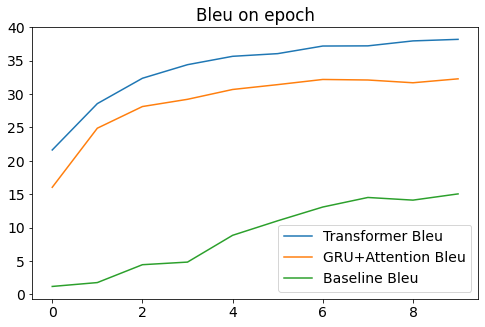

In [ ]:
fig = plt.figure(figsize=(8,5))
plt.plot(bleu_transf, label ="Transformer Bleu")
plt.plot(bleu_att, label ="GRU+Attention Bleu")
plt.plot(bleu_baseline, label ="Baseline Bleu")
plt.legend()
plt.title("Bleu on epoch")
plt.show()

Видно, что на моделях с attention (в данной архитектуре) рост Bleu на валидации выходит на плато



Дольше всего обучается модель gru+attention, она же имеет больше всего параметров. Transformer обучался быстрее всего и продемонстировал лучшие способности на нашем примере. Действительно, эффектно. 



In [ ]:
comparison = {'Model': ['LSTM-baseline', 'GRU+Attention', 'Transformer'], 
              'Bleu': [bl_test_bleu, att_test_bleu, tr_test_bleu], 
              'Loss':[bl_test_loss, att_test_loss, tr_test_loss],
              }
df_comparison = pd.DataFrame(comparison).T
df_comparison

,0,1,2
Model,LSTM-baseline,GRU+Attention,Transformer
Bleu,14.993062,33.207674,38.29633
Loss,4.608991,4.386877,1.567202


Тут в очередной раз умер колаб, не сохранив переменные, проще было уже перепечатать руками:

In [7]:
comparison = { 
              'Bleu': [14.99, 33.21, 38.29], 
              'Loss':[4.61, 4.39, 1.57],
              'Perplexity': [math.exp(4.61), math.exp(4.39), math.exp(1.57)],
              'Trainable parameters': ['14.899.014', '22.585.158', '8.497.464'],
              'Train last epoch time':["1m 47s","4m 27s","0m 40s"], 
              'Inference 1batch-32':[0.0816, 0.0955, 0.0258], 
                            }
df_comparison = pd.DataFrame(comparison, index = ['LSTM-baseline', 'GRU+Attention', 'Transformer'])
df_comparison

,Bleu,Loss,Perplexity,Trainable parameters,Train last epoch time,Inference 1batch-32
LSTM-baseline,14.99,4.61,100.484150,14.899.014,1m 47s,0.0816
GRU+Attention,33.21,4.39,80.640419,22.585.158,4m 27s,0.0955
Transformer,38.29,1.57,4.806648,8.497.464,0m 40s,0.0258


Теперь видно, что разница в Loss действительно не слишком интуитивно понятна: между первыми двумя моделями разница этого параметра субъективно мала, а на экспоненте perplexity разница уже чувствуется, и всё же характеризует прогресс модели с attention относительно бейзлайн модели.


# Библиотека Transformers и предобученная Helsinki-NLP/opus-mt-ru-en
На основе https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb

В ходе изучения задания я узнала, что всё написано до нас:) И есть готовая библиотека. Надо попробовать.

Здесь pipeline сильно отличается от предыдущих моделей, не стала выносить отдельно и включать в сравнения.

In [ ]:
import transformers

In [ ]:
model_checkpoint = "Helsinki-NLP/opus-mt-ru-en"

In [ ]:
with open(path_to_data, 'r') as f:
    lines = f.readlines()
lines2 = [line.strip().split('\t') for line in lines]

In [ ]:
#idea from stackoverflow
df = pd.DataFrame(lines2, columns=['en', 'ru'])
train_data, valid_data, test_data = np.split(df.sample(frac=1), [int(.8*len(df)), int(.95*len(df))]) 
json_train = {'data': {'translation': [{'en': line[0], 'ru': line[1]} for line in train_data.values]}}
json_valid = {'data': {'translation': [{'en': line[0], 'ru': line[1]} for line in valid_data.values]}}
json_test = {'data': {'translation': [{'en': line[0], 'ru': line[1]} for line in test_data.values]}}
with open('data_j_tr.json', 'w') as f:
    f.write(json.dumps(json_train))
with open('data_j_v.json', 'w') as f:
    f.write(json.dumps(json_valid))
with open('data_j_te.json', 'w') as f:
    f.write(json.dumps(json_test))

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
from datasets import load_dataset, load_metric

raw_datasets = load_dataset('json', data_files={'train': 'data_j_tr.json', 'validation': 'data_j_v.json', 'test': 'data_j_te.json'}, field='data')
metric = load_metric("sacrebleu")

In [ ]:
if "mbart" in model_checkpoint:
    tokenizer.src_lang = "ru_RU"
    tokenizer.tgt_lang = "en_XX"

In [ ]:
if model_checkpoint in ["t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b"]:
    prefix = "translate Russian to English: "
else:
    prefix = ""

In [ ]:
max_input_length = 100
max_target_length = 100
source_lang = "ru"
target_lang = "en"

def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq,Seq2SeqTrainingArguments, Seq2SeqTrainer

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
batch_size = 16
args = Seq2SeqTrainingArguments(
    f"ru-to-en",
    evaluation_strategy = "epoch",
  
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    
)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Using amp half precision backend


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: translation. If translation are not expected by `MarianMTModel.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 40000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7500


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,1.220800,1.105677,36.145500,21.072800
2,1.052000,1.046674,37.526000,20.945600
3,0.978300,1.029544,38.182700,20.996300


Saving model checkpoint to ru-to-en/checkpoint-500
Configuration saved in ru-to-en/checkpoint-500/config.json
Model weights saved in ru-to-en/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ru-to-en/checkpoint-500/tokenizer_config.json
Special tokens file saved in ru-to-en/checkpoint-500/special_tokens_map.json
Saving model checkpoint to ru-to-en/checkpoint-1000
Configuration saved in ru-to-en/checkpoint-1000/config.json
Model weights saved in ru-to-en/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ru-to-en/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ru-to-en/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ru-to-en/checkpoint-1500
Configuration saved in ru-to-en/checkpoint-1500/config.json
Model weights saved in ru-to-en/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ru-to-en/checkpoint-1500/tokenizer_config.json
Special tokens file saved in ru-to-en/checkpoint-1500/special_tokens_map.json
Sav

TrainOutput(global_step=7500, training_loss=1.1425041341145834, metrics={'train_runtime': 2552.8627, 'train_samples_per_second': 47.006, 'train_steps_per_second': 2.938, 'total_flos': 1910151677214720.0, 'train_loss': 1.1425041341145834, 'epoch': 3.0})

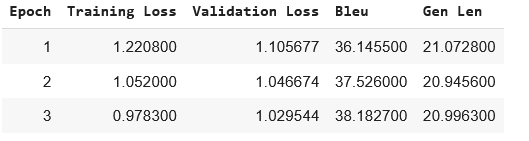

In [ ]:
from transformers import pipeline

translator = pipeline("translation_ru_to_en", model=model, tokenizer=tokenizer, device=0)

In [ ]:
test_data = test_data.reset_index()

In [ ]:
idx = [1, 2000, 33, 100, 1119, 11]
for i in idx:
  inputs = test_data.loc[i, 'ru']
  target = test_data.loc[i, 'en']
  translation = translator(inputs, return_text=True)
  translation = [t["translation_text"] for t in translation]
  print("For translation:", inputs)
  print("Original:", target)
  print("Generated:", *translation)
  print()
  

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


For translation: До Длинного рынка и Двора Артура - 100 метров.
Original: The property is 100 metres from Long Market and 100 metres from Artus Court.
Generated: The Long Market and Arthur's Court are 100 metres away.

For translation: Апартаменты Vogelstein расположены в городе Гриндельвальд, в 3 км от горы Фирст и в 1,4 км от горнолыжного подъемника Гриндельвальд Грунд - Мэннлихен.
Original: Vogelstein is a sstudio located in Grindelwald. The property is 3.0 km from First and 1.4 km from Ski Lift Grindelwald Grund - Männlichen.
Generated: Apartment Vogelstein is located in Grindelwald, 3 km from the Firest Mountain and 1.4 km from the Grindelwald Grund - Mannlichen Ski Lift.

For translation: Персонал может заказать билеты на шоу фламенко и экскурсии в Альгамбру.
Original: They can also book tickets for flamenco shows or visits to the Alhambra.
Generated: Staff can book tickets for the Flamenco Show and excursions to Alhambra.

For translation: В ванной комнате предоставляется фен.
O

Заметное улучшение качества, Bleu уже на первой эпохе составил 36. Учится довольно долго, не стала делать много эпох, суть понятна. Колаб пытался умирать, снизила батч. На взгляд всё тоже весьма хорошо. Сгенерированный перевод местами мне нравится даже больше, чем предоставляемый в датасете.

Здесь опять момент задуматься о метриках качества перевода. Bleu одинаков с самописным transformer, однако, очевидно, что качество перевода лучше. И этот факт Loss(ну и заодно perplexity) описывает в итоге лучше. Для себя сформулировала по ощущениям от данной работы, что на ранней стадии Bleu показателен, а для более точной оценки я бы смотрела в итоге perplexity.

# mBart
Дальше я хотела поупражняться с BERT, но возникли трудности, которые я уже не осилила, оставлю себе это на лето. В процессе изучения наткнулась на такое развитие как mBart, было интересно просто посмотреть:

In [ ]:
!pip install -q transformers
!pip install -q sentencepiece

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

In [ ]:
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt", src_lang="ru_RU")

In [ ]:
idx = [1, 2000, 33, 100, 1119, 11]
for i in idx:
  text = test_data.loc[i, 'ru']
  model_inputs = tokenizer(text, return_tensors = "pt")
  generated_tokens = model.generate(**model_inputs, forced_bos_token_id = tokenizer.lang_code_to_id ["en_XX"])
  translation = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
  print("For translation:", text)
  print("Original:", test_data.loc[i, 'en'])
  print("Generated:", *translation)
  print()

For translation: До Длинного рынка и Двора Артура - 100 метров.
Original: The property is 100 metres from Long Market and 100 metres from Artus Court.
Generated: The long market and Arthur's Palace are 100 meters away.

For translation: Апартаменты Vogelstein расположены в городе Гриндельвальд, в 3 км от горы Фирст и в 1,4 км от горнолыжного подъемника Гриндельвальд Грунд - Мэннлихен.
Original: Vogelstein is a sstudio located in Grindelwald. The property is 3.0 km from First and 1.4 km from Ski Lift Grindelwald Grund - Männlichen.
Generated: Vogelstein Apartments are located in the town of Greendelwald, 3 km from Mount First and 1.4 km from the Greendelwald Grund-Mannlichen ski lift.

For translation: Персонал может заказать билеты на шоу фламенко и экскурсии в Альгамбру.
Original: They can also book tickets for flamenco shows or visits to the Alhambra.
Generated: The staff can order tickets for Flamenco shows and excursions to the Alhambra.

For translation: В ванной комнате предостав

Качество перевода на глаз хорошее. Честно говоря, в предобученных вариантах иногда сгенерированный перевод мне кажется точнее оригинала из тестовой выборки. 

Мне, как человеку, первый раз изучающему NLP(не считая задания с Шекспиром в 1м семестре) было очень интересно и не просто, поняла, что это задание, как ремонт по Жванецкому - невозможно закончить, можно только прекратить. Вариантов что еще можно сделать и попробовать даже в рамках текущей модели - много. Не закрыт гештальт по доделать руками Bert, CNN, BPE. Спасибо за задание и за большое количество открывшихся направлений, которые стоит изучить.